In [2]:
import pandas as pd
import numpy as np
import dateutil.parser
import matplotlib.pyplot as plt
import seaborn as sns
import calendar
import json
import datetime
import pickle
from sklearn.metrics import *
from sklearn.neighbors import KNeighborsClassifier
from sklearn.learning_curve import learning_curve
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.cross_validation import train_test_split, cross_val_score, cross_val_predict
from urllib2 import Request, urlopen
from pandas.io.json import json_normalize
from patsy import dmatrices
%matplotlib inline

In [3]:
divvy_df = pd.read_csv('bigfile.csv', sep = ',')

In [4]:
divvy_df.head()

,trip_id,starttime,stoptime,bikeid,tripduration,from_station_id,from_station_name,to_station_id,to_station_name,usertype,gender,birthyear
0,2355134,6/30/2014 23:57,7/1/2014 0:07,2006,604,131,Lincoln Ave & Belmont Ave,303,Broadway & Cornelia Ave,Subscriber,Male,1988
1,2355133,6/30/2014 23:56,7/1/2014 0:00,2217,263,282,Halsted St & Maxwell St,22,May St & Taylor St,Subscriber,Male,1992
2,2355130,6/30/2014 23:33,6/30/2014 23:35,2798,126,327,Sheffield Ave & Webster Ave,225,Halsted St & Dickens Ave,Subscriber,Male,1993
3,2355129,6/30/2014 23:26,7/1/2014 0:24,173,3481,134,Peoria St & Jackson Blvd,194,State St & Wacker Dr,Subscriber,Female,1988
4,2355128,6/30/2014 23:16,6/30/2014 23:26,173,638,320,Loomis St & Lexington St,134,Peoria St & Jackson Blvd,Subscriber,Female,1988


In [5]:
divvy_df.shape
#holy cow batman, 2,454,634 total divvy trips in 2014.

(2454634, 12)

In [6]:
divvy_df['to_station_id'].nunique()
#there are 300 unique station IDs but the range is from 5 to 351

300

In [7]:
#converting to datetime objects and then wiping out the mins and secs so we can bin by hour.

def hourbinner(fulltime):
    return dateutil.parser.parse(fulltime).replace(minute=0, second=0)

In [8]:
#making a deep copy of the DF.

divvy_hr_df = divvy_df.copy(deep = True)

In [9]:
#converting to datetime objects and then wiping out the mins and secs so we can bin by hour.

divvy_hr_df.starttime = divvy_hr_df.starttime.apply(lambda x: hourbinner(x))
divvy_hr_df.stoptime = divvy_hr_df.stoptime.apply(lambda x: hourbinner(x))

#this took like 5 mins, at least 

KeyboardInterrupt: 

In [ ]:
fromstation_starttime = divvy_hr_df.groupby(['from_station_name', 'starttime']).size()

#we have a multi-index, so lets start by moving 'from_station_name' out, using unstack.
ts = fromstation_starttime.unstack(level=0)

#now with a single-lvl DatetimeIndex, reindex by filling all empty values with 0
index = pd.date_range('2014-01-01', '2014-12-31', freq='H')
ts = ts.reindex(index, fill_value = 0)

#fill NaNs with 0s so they don't go away when you restack
ts = ts.fillna(0)

#restack
ts = ts.stack()

"""what's happening here"""
ts = ts.swaplevel(0,1)
ts = ts.sortlevel()
print 'Done here.'

In [ ]:
#same as above
tostation_stoptime = divvy_hr_df.groupby(['to_station_name', 'stoptime']).size()
vs = tostation_stoptime.unstack(level=0)
vs = vs.reindex(index, fill_value = 0)
vs = vs.fillna(0)
vs = vs.stack()
vs = vs.swaplevel(0,1)
vs = vs.sortlevel()
print 'Done here.'

In [ ]:
combined = pd.concat([ts, vs], axis=1)
combined.columns = ['outflow', 'inflow']
print 'Done here.'

In [ ]:
combined['flowdiff'] = combined['inflow'] - combined['outflow']
combined.index.names = ['station_name', 'hourly_time']
print 'Done here.'

In [ ]:
flowdiff_distrib = combined['flowdiff'].value_counts()
percents = (flowdiff_distrib/2454634*100).sort_index()

categ = percents.index.tolist()
vals = percents.values.tolist()

fig = plt.figure(figsize = (12,6))
ax = fig.add_subplot(111)

plt.bar(categ, vals, color='skyblue')
ax.set_xlabel("Net Bike Flow", fontsize = 12.5)
ax.set_ylabel("Counts", labelpad = 30, fontsize = 12.5).set_rotation(0)
plt.xticks(np.arange(-80,81,10), np.arange(-80,81,10), x=1.02)
plt.title("Divvy Bike Flow Distribution", fontsize = 20, y=1.025)
plt.xlim(-80,80)


In [ ]:
combined.head()

In [ ]:
#flattened the multi-index DF from above.

combined.reset_index(inplace=True)

In [ ]:
combined.head()

In [ ]:
#extracting the IDs to go with the station_name so we can match w the JSON info later.

#make a deep copy of just the station IDs and station names.
just_ID_name = divvy_df.copy(deep=True)[['from_station_id', 'from_station_name']]

#just because.
just_ID_name = just_ID_name.rename(columns = {'from_station_name':'station_name'})

#if you don't drop duplicates, it becomes a mess to join on.
just_ID_name = just_ID_name.drop_duplicates()

In [ ]:
#merging the dataframes, it will automatically recognize and merge on the same key in this instance.
result = combined.merge(just_ID_name)
result = result.rename(columns = {'from_station_id':'id'})
print 'Done here.'

In [ ]:
result.head()

In [ ]:
#getting the divvy JSON file 
request= Request('http://www.divvybikes.com/stations/json')
response = urlopen(request)
api = response.read()
api_data = json.loads(api)
#json_normalize takes a dict or list of dicts and normalizes this semi-structured data into a flat table
api_df = json_normalize(api_data['stationBeanList'])
api_df = api_df[["id", "latitude", "longitude", "stationName", "totalDocks"]]

In [ ]:
api_df.head()

In [ ]:
#the api columns are in unicode, so we need them in utf-8 string format for merge matching purposes
api_df.columns = map(lambda x: x.encode('utf-8'), api_df.columns)
#time to merge on id!
bigresult = pd.merge(result, api_df, on='id')

In [ ]:
#dropping the extra stationName column
bigresult.drop(bigresult.columns[[-2]], axis = 1, inplace = True)

In [ ]:
bigresult.head()

In [ ]:
#creating extra predictor variables.

bigresult['dayofwk'] = bigresult['hourly_time'].apply(lambda x: calendar.day_name[x.weekday()])
bigresult['hour'] = bigresult['hourly_time'].apply(lambda x: x.hour)

print 'Done here.'

In [ ]:
#Reading in the weather data to append to our bigresult dataframe.

weather_df = pd.read_csv("2014weatherinfo.csv", sep = ',')
print 'Done here.'

In [ ]:
weather_df.shape

In [ ]:
weather_df = weather_df.rename(columns = {'Unnamed: 0':'hourly'})

In [ ]:
#new hourbinner function that gets rid of the tzinfo parameter
def tz_hourbinner(fulltime):
    return dateutil.parser.parse(fulltime).replace(minute=0, second=0, tzinfo=None)

In [ ]:
weather_df.hourly = weather_df.hourly.apply(lambda x: tz_hourbinner(x))

In [ ]:
print type(weather_df.hourly[0])

In [ ]:
bigresult.head()

In [ ]:
weather_df.head()

In [ ]:
weather_df = weather_df.rename(columns = {'hourly':'hourly_time'})

In [ ]:
#merging those two dataframes on the common hourly_time column to create ... the big kahuna.

bigkahuna = pd.merge(bigresult, weather_df, on="hourly_time")
print 'Done here.'

In [ ]:
#sorting by station_name and then hourly_time, and then resetting the index

bigkahuna = bigkahuna.sort(['station_name', 'hourly_time']).reset_index(drop=True)

In [ ]:
bigkahuna.head()

In [ ]:
bigkahuna.shape

In [ ]:
#adding a flux column that categorizes both excessive inflow and outflow based on a threshold percentage 
#calculated on flowdiff/totalDocks for each station. (Done for every hour, as our dataframe is)

bigkahuna['flux'] = 0
bigkahuna.loc[(bigkahuna['flowdiff'] > 0) & (bigkahuna.flowdiff.abs() > (bigkahuna.totalDocks * 0.2)), 'flux'] = 1
bigkahuna.loc[(bigkahuna['flowdiff'] < 0) & (bigkahuna.flowdiff.abs() > (bigkahuna.totalDocks * 0.2)), 'flux'] = 2
print 'Done here.'

In [ ]:
bigkahuna['flux'].value_counts()

In [ ]:
with open('bigkahuna.pkl', 'w') as picklefile:
    pickle.dump(bigkahuna, picklefile)
    
print 'Done here.'

In [ ]:
smallerkahuna = bigkahuna[['station_name', 'dayofwk', 'hour', 'summary', 'temperature', 'flowdiff']]
doesthiswork = smallerkahuna.groupby(['station_name', 'hour']).flowdiff.sum()

In [82]:
#how to turn that groupby into a DataFrame - MEMORIZE THIS SHIT.
vs = doesthiswork.unstack(level=0)
vs = vs.stack()
vs = vs.swaplevel(0,1)
vs = vs.sortlevel()
vs.index.names = ['station_name', 'hour']
vs = pd.DataFrame(vs)
vs.reset_index(inplace=True)
vs.columns = ["statition_name","hour", "total net flow"]
vs

,statition_name,hour,total net flow
0,900 W Harrison,0,-27
1,900 W Harrison,1,-9
2,900 W Harrison,2,-17
3,900 W Harrison,3,3
4,900 W Harrison,4,1
5,900 W Harrison,5,11
6,900 W Harrison,6,43
7,900 W Harrison,7,143
8,900 W Harrison,8,323
9,900 W Harrison,9,258


In [83]:
vs3 = vs.pivot("statition_name","hour", "total net flow")
vs3.index.name = None
vs3.columns.name = None

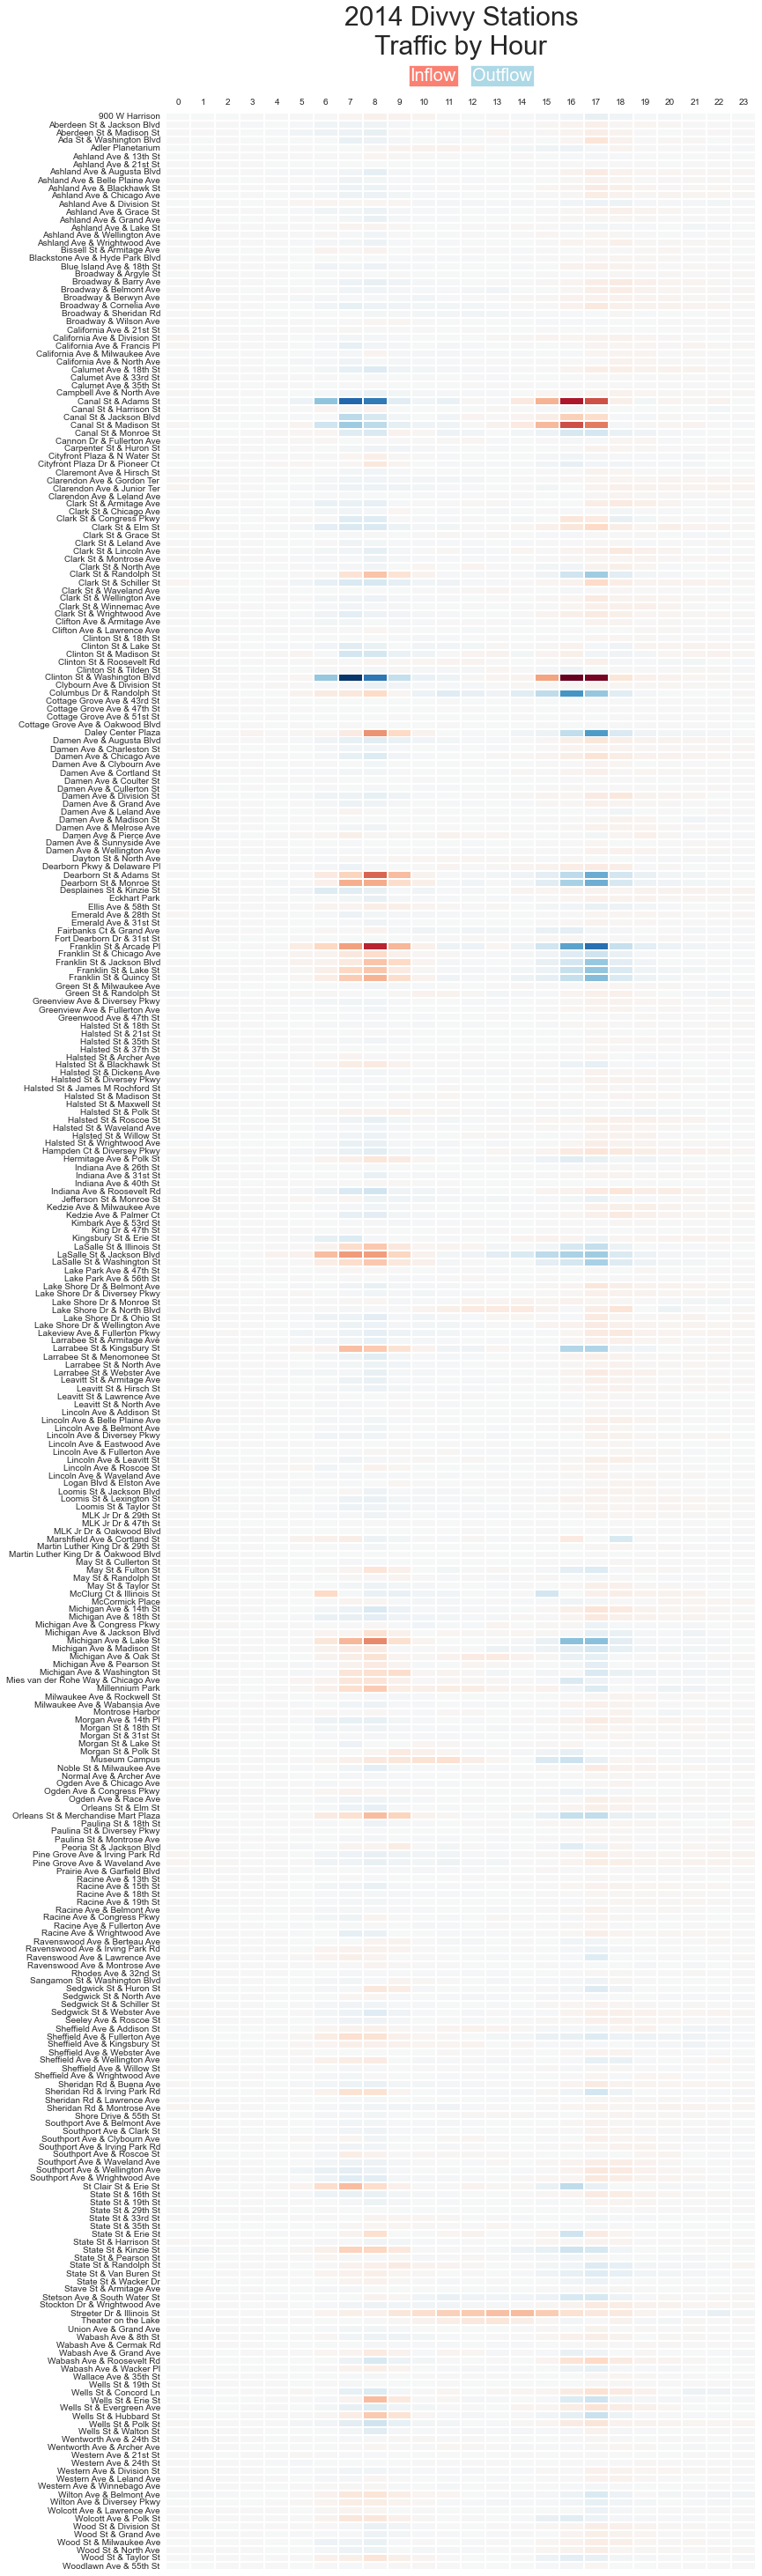

In [88]:
plt.figure(figsize=(12,50))
ax = plt.subplot(111)
sns.heatmap(vs3, linewidths=0.5, cbar=False)
ax.tick_params(labelbottom='off',labeltop='on')
plt.title("2014 Divvy Stations\nTraffic by Hour", y= 1.022, fontsize = 30)
ax.text(10, 315, 'Inflow', backgroundcolor = 'salmon', color = 'White', fontsize = 20)
ax.text(12.5, 315, 'Outflow', backgroundcolor = 'lightblue', color = 'White', fontsize = 20)
plt.savefig("DivvyHeatmap.png", bbox_inches='tight')